# Prediction with Machine Learning for Economists - Assignment 3

## - *Data Preparation Part*

Done by: Yu Xu
    
Date: 10 March 2023

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from plotnine import *

warnings.filterwarnings("ignore")

In [2]:
# Import the prewritten helper functions
from py_helper_functions import *

## Import Data

In [3]:
data = pd.read_csv("cs_bisnode_panel.csv")

In [4]:
# check missing values
missing_vals = data.isnull().sum()
print(missing_vals)

comp_id                      0
begin                        0
end                          0
COGS                    269572
amort                     8040
curr_assets                131
curr_liab                  131
extra_exp                18529
extra_inc                18529
extra_profit_loss        17203
finished_prod           270344
fixed_assets               131
inc_bef_tax               7437
intang_assets              140
inventories                131
liq_assets                 131
material_exp              8040
net_dom_sales           269572
net_exp_sales           269572
personnel_exp             8040
profit_loss_year          9884
sales                     7437
share_eq                   131
subscribed_cap             131
tang_assets               1470
wages                   269846
D                       287829
balsheet_flag                0
balsheet_length              0
balsheet_notfullyear         0
year                         0
founded_year             56457
exit_yea

In [5]:
# drop variables with many NAs
data = data.drop(
    columns=["COGS", "finished_prod", "net_dom_sales", "net_exp_sales", "wages"]
)
data = data.query("year !=2016")

## Lable Engineering

In [6]:
# add all missing year and comp_id combinations -
# originally missing combinations will have NAs in all other columns
data = (
    data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
data = data.replace("toReplace", np.nan)  # only way I could define it as NaN

In [7]:
# scale sales by million and make log transformation
data["sales"] = np.where(
    data["sales"] < 0, 1, data["sales"]
)  # has to be outside of assin()
data = data.assign(
    ln_sales=np.where(
        data["sales"] > 0,
        np.log(data["sales"]),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),  # NaN remain NaN
    sales_mil=data["sales"] / 1000000,
    sales_mil_log=np.where(
        data["sales"] > 0,
        np.log(data["sales"] / 1000000),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
)

In [8]:
# define growth rate (log subtraction)
data["d1_sales_mil_log"] = data["sales_mil_log"] - data.groupby("comp_id")[
    "sales_mil_log"
].shift(1)

In [9]:
# replace w 0 for new firms + add dummy to capture it
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"]
)
data["new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)),
)
data["d1_sales_mil_log"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["d1_sales_mil_log"])
)
data["new"] = np.where(data["d1_sales_mil_log"].isna(), 1, data["new"])
data["d1_sales_mil_log"] = np.where(
    data["d1_sales_mil_log"].isna(), 0, data["d1_sales_mil_log"]
)

In [10]:
# scale profit/loss by sales and generate the first difference
data["profit_loss_year_pl"] = data["profit_loss_year"].div(
    data["sales"], axis="index"
)
data["profit_loss_year_pl"] = np.where(
    data["profit_loss_year_pl"].isna(), np.nan, np.where((data["profit_loss_year_pl"] < -1), -1, data["profit_loss_year_pl"])
)
data["profit_loss_year_pl"] = np.where(
    data["profit_loss_year_pl"].isna(), np.nan, np.where((data["profit_loss_year_pl"] > 1), 1, data["profit_loss_year_pl"])
)
data["d1_profit_loss_year_pl"] = data["profit_loss_year_pl"] - data.groupby("comp_id")[
    "profit_loss_year_pl"
].shift(1)
data["d1_profit_loss_year_pl"] = np.where(
    data["d1_profit_loss_year_pl"].isna(), 0, data["d1_profit_loss_year_pl"]
)

In [11]:
# Keep data from 2010 to 2015
data = data.query("2010 <= year <= 2015")

In [12]:
data["d1_sales_mil_log"].describe()

count    278472.000000
mean          0.042740
std           1.063275
min         -13.815511
25%           0.000000
50%           0.000000
75%           0.000000
max          14.634809
Name: d1_sales_mil_log, dtype: float64

In [13]:
# generate fast_growth; if sales growth rate is larger than the average sales growth rate plus
# the standard devidation, then the firm is fast growing 
data["fast_growth"] = ((data["d1_sales_mil_log"] > 0.1)   #((data["d1_sales_mil_log"].mean()) + 1/2 * (data["d1_sales_mil_log"].std()))) 
                       & (False == data["d1_sales_mil_log"].isna())).astype(int)

In [14]:
data["fast_growth"].value_counts()

0    234899
1     43573
Name: fast_growth, dtype: int64

## Sample Design

I have already kept data from 2010 to 2015 in the previous part.

In [15]:
# look at firms below 10m euro revenues and above 1000 euros
data = data.query("sales_mil<=10 & sales_mil>=0.001")

In [16]:
data["fast_growth"].value_counts()

0    90514
1    37841
Name: fast_growth, dtype: int64

In [17]:
data["fast_growth"].describe()

count    128355.000000
mean          0.294815
std           0.455961
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: fast_growth, dtype: float64

## Feature Engineering

In [18]:
# generate year category variable
data["year_m"] = data["year"].astype("category")

In [19]:
# change some industry category codes
data["ind2_cat"] = data["ind2"].copy()
data["ind2_cat"] = np.where(data["ind2"] > 56, 60, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"] < 26, 20, data["ind2_cat"])
data["ind2_cat"] = np.where(
    (data["ind2"] < 55) & (data["ind2"] > 35), 40, data["ind2_cat"]
)
data["ind2_cat"] = np.where(data["ind2"] == 31, 30, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"].isna(), 99, data["ind2_cat"])

In [20]:
data.groupby("ind2_cat").count()["comp_id"]

ind2_cat
20.0      310
26.0     6428
27.0     3898
28.0    11606
29.0     1703
30.0     1017
32.0      829
33.0    11371
35.0        2
40.0     1250
55.0    13637
56.0    74806
60.0     1460
99.0       38
Name: comp_id, dtype: int64

In [21]:
# Firm characteristics
data["age2"] = data["age"] ** 2
data["foreign_management"] = np.where(
    data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0)
)
data["gender_m"] = data["gender"].astype("category")
data["m_region_loc"] = data["region_m"].astype("category")

In [22]:
###########################################################
# look at more financial variables, create ratios
###########################################################

# assets can't be negative. Change them to 0 and add a flag.
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)
data.groupby("flag_asset_problem").count()["comp_id"]

flag_asset_problem
0.0    128260
1.0        65
Name: comp_id, dtype: int64

In [23]:
data["intang_assets"] = np.where(data["intang_assets"] < 0, 0, data["intang_assets"])
data["curr_assets"] = np.where(data["curr_assets"] < 0, 0, data["curr_assets"])
data["fixed_assets"] = np.where(data["fixed_assets"] < 0, 0, data["fixed_assets"])

In [24]:
# generate total assets
data["total_assets_bs"] = (
    data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
)
data["total_assets_bs"].describe()

count    1.283250e+05
mean     2.715624e+05
std      1.875274e+06
min      0.000000e+00
25%      7.577778e+03
50%      2.635556e+04
75%      1.037222e+05
max      3.190691e+08
Name: total_assets_bs, dtype: float64

In [25]:
# deal with financial varaiables
pl_names = [
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "inc_bef_tax",
    "inventories",
    "material_exp",
    "profit_loss_year",
    "personnel_exp",
]
bs_names = [
    "intang_assets",
    "curr_liab",
    "fixed_assets",
    "liq_assets",
    "curr_assets",
    "share_eq",
    "subscribed_cap",
    "tang_assets",
]

In [26]:
# divide all pl_names elements by sales and create new column for it
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)

In [27]:
# divide all bs_names elements by total_assets_bs and create new column for it
data[[col + "_bs" for col in bs_names]] = (
    data[bs_names]
    .div(data["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    data[col + "_bs"] = np.where(
        data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
    )

In [28]:
########################################################################
# creating flags, and winsorizing tails
########################################################################

# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)

In [29]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
)
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
)
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)
data[[col + "_quad" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, data[anyof] ** 2
)

In [30]:
# dropping flags with no variation
flag_columns = [col for col in data.columns if "flag" in col]
data = data.drop(
    data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1
)

In [31]:
########################################################################
# additional
# including some imputation
########################################################################

# CEO age
data["ceo_age"] = data["year"] - data["birth_year"]
data = data.assign(
    flag_low_ceo_age=(data["ceo_age"] < 25).astype(int),
    flag_high_ceo_age=(data["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age=(data["ceo_age"].isna()).astype(int),
)


data["ceo_age"] = np.where(data["ceo_age"] < 25, 25, data["ceo_age"])
data["ceo_age"] = np.where(data["ceo_age"] > 75, 75, data["ceo_age"])
data["ceo_age"] = np.where(
    data["ceo_age"].isna(), data["ceo_age"].mean(), data["ceo_age"]
)
data["ceo_young"] = (data["ceo_age"] < 40).astype(int)

In [32]:
# number emp, very noisy measure
data["labor_avg_mod"] = np.where(
    data["labor_avg"].isna(), data["labor_avg"].mean(), data["labor_avg"]
)
data["flag_miss_labor_avg"] = (data["labor_avg"].isna()).astype(int)

In [33]:
data["labor_avg"].describe()

count    104401.000000
mean          0.666376
std           1.712817
min           0.000000
25%           0.111111
50%           0.250000
75%           0.568182
max          64.583336
Name: labor_avg, dtype: float64

In [34]:
data["labor_avg_mod"].describe()

count    128355.000000
mean          0.666376
std           1.544744
min           0.000000
25%           0.151515
50%           0.340278
75%           0.666376
max          64.583336
Name: labor_avg_mod, dtype: float64

In [35]:
data = data.drop(["labor_avg"], axis=1)

In [36]:
# create category type variables
data["urban_m"] = data["urban_m"].astype("category")
data["ind2_cat"] = data["ind2_cat"].astype("category")
data["fast_growth_f"] = data["fast_growth"].astype("category")
data["fast_growth_f"] = data["fast_growth_f"].cat.rename_categories(["low growth", "fast growth"])

In [37]:
########################################################################
# sales
########################################################################
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2

There is a slightly inverted U-shaped relationship between sales_mil_log and fast_growth, with fast_growth increasing with sales_mil_log at the beginning and then decreasing after reaching a certain level, which is consistent with the regression results. This is because when sales_mil_log is large to a certain degree, the increase rate decreases because of the large base.

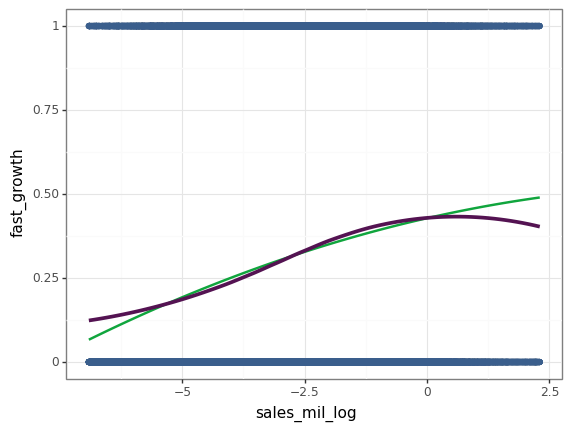

<ggplot: (8794193998957)>

In [39]:
(
    ggplot(data, aes(x="sales_mil_log", y="fast_growth"))
    + geom_point(color=color[0])
    + geom_smooth(method="lm", formula="y ~ x + I(x**2)", color=color[1], se=False)
    + geom_smooth(method="loess", color=color[2], se=False, size=1.5, span=0.9)
    + labs(x="sales_mil_log", y="fast_growth")
    + theme_bw()
)

In [40]:
# Linear regressions
ols_s = smf.ols("fast_growth ~ sales_mil_log + sales_mil_log_sq", data=data).fit()
print(ols_s.summary())

                            OLS Regression Results                            
Dep. Variable:            fast_growth   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     2252.
Date:                Fri, 10 Mar 2023   Prob (F-statistic):               0.00
Time:                        22:23:30   Log-Likelihood:                -79110.
No. Observations:              128355   AIC:                         1.582e+05
Df Residuals:                  128352   BIC:                         1.583e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.4281      0.003  

There are very similar patterns for the profit & loss change (d1_profit_loss_year_pl) and sales chage with fast_growth, which indicates the profit & loss change is a very important variable for predictions (I created the target variable based on the sales change, so I don't include it into predictions).

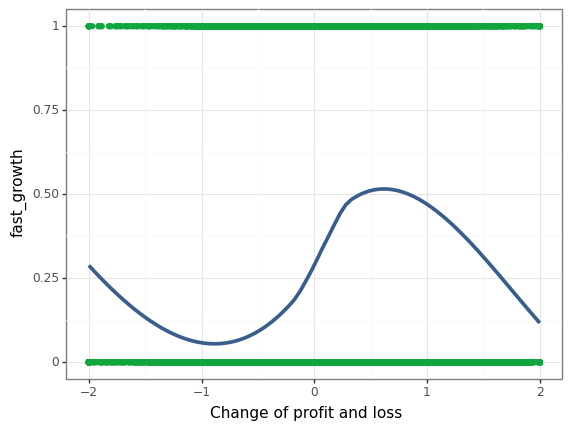

<ggplot: (8794006493522)>

In [41]:
########################################################################
# Profit and loss change & sales change
########################################################################

# lowess
(
    ggplot(data, aes(x="d1_profit_loss_year_pl", y="fast_growth"))
    + geom_point(color=color[1])
    + geom_smooth(method="loess", color=color[0], se=False, size=1.5, span=0.9)
    + labs(x="Change of profit and loss", y="fast_growth")
    + scale_x_continuous()
    + theme_bw()
)


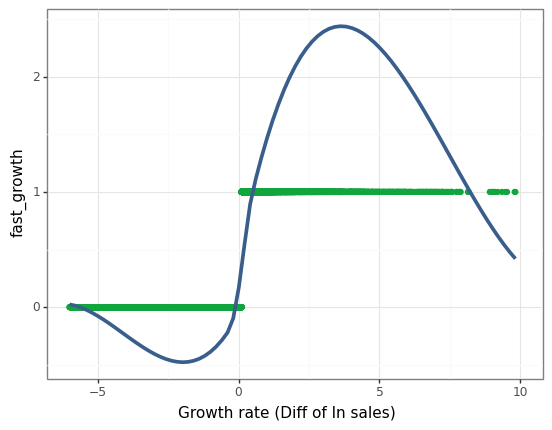

<ggplot: (8794010882347)>

In [42]:
(
    ggplot(data, aes(x="d1_sales_mil_log", y="fast_growth"))
    + geom_point(color=color[1])
    + geom_smooth(method="loess", color=color[0], se=False, size=1.5, span=0.9)
    + labs(x="Growth rate (Diff of ln sales)", y="fast_growth")
    + scale_x_continuous(limits=(-6, 10), breaks=seq(-5, 10, by=5))
    + theme_bw()
)

In [43]:
# generate variables ---------------------------------------------------

data["flag_low_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] < -1.5, 1, 0)
data["flag_high_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] > 1.5, 1, 0)
data["d1_sales_mil_log_mod"] = np.where(
    data["d1_sales_mil_log"] < -1.5,
    -1.5,
    np.where(data["d1_sales_mil_log"] > 1.5, 1.5, data["d1_sales_mil_log"]),
)
data["d1_sales_mil_log_mod_sq"] = data["d1_sales_mil_log_mod"] ** 2

In [44]:
data["flag_low_d1_profit_loss_year_pl"] = np.where(data["d1_profit_loss_year_pl"] < -1.5, 1, 0)
data["flag_high_d1_profit_loss_year_pl"] = np.where(data["d1_profit_loss_year_pl"] > 1.5, 1, 0)
data["d1_profit_loss_year_pl_mod"] = np.where(
    data["d1_profit_loss_year_pl"] < -1.5,
    -1.5,
    np.where(data["d1_profit_loss_year_pl"] > 1.5, 1.5, data["d1_profit_loss_year_pl"]),
)
data["d1_profit_loss_year_pl_mod_sq"] = data["d1_profit_loss_year_pl_mod"] ** 2

In [45]:
# no more imputation, drop obs if key vars missing
data = data.dropna(subset=["liq_assets_bs", "foreign", "ind"])

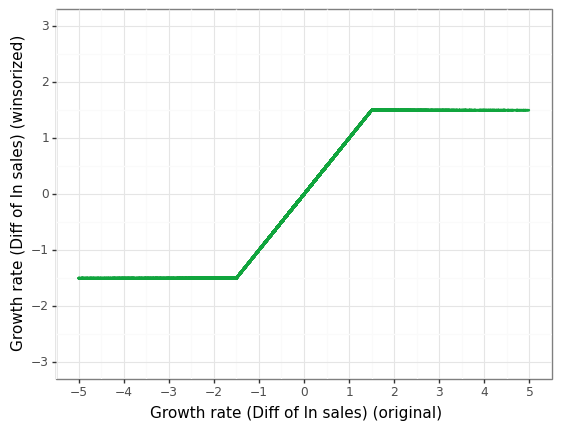

<ggplot: (8794176009114)>

In [46]:
(
    ggplot(data, aes(x="d1_sales_mil_log", y="d1_sales_mil_log_mod"))
    + geom_point(size=0.1, color=color[1])
    + labs(
        x="Growth rate (Diff of ln sales) (original)",
        y="Growth rate (Diff of ln sales) (winsorized)",
    )
    + scale_x_continuous(limits=(-5, 5), breaks=seq(-5, 5, by=1))
    + scale_y_continuous(limits=(-3, 3), breaks=seq(-3, 3, by=1))
    + theme_bw()
)

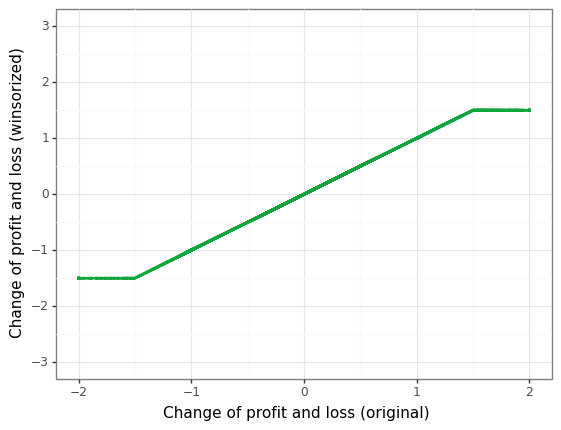

<ggplot: (8794058311075)>

In [47]:
(
    ggplot(data, aes(x="d1_profit_loss_year_pl", y="d1_profit_loss_year_pl_mod"))
    + geom_point(size=0.1, color=color[1])
    + labs(
        x="Change of profit and loss (original)",
        y="Change of profit and loss (winsorized)",
    )
    + scale_x_continuous()
    + scale_y_continuous(limits=(-3, 3), breaks=seq(-3, 3, by=1))
    + theme_bw()
)

In [48]:
# Check which columns have missing values
null_cols = data.isnull().sum()
print(null_cols)

year                                  0
comp_id                               0
begin                                 0
end                                   0
amort                               183
                                   ... 
d1_sales_mil_log_mod_sq               0
flag_low_d1_profit_loss_year_pl       0
flag_high_d1_profit_loss_year_pl      0
d1_profit_loss_year_pl_mod            0
d1_profit_loss_year_pl_mod_sq         0
Length: 123, dtype: int64


In [49]:
# Find columns with missing values
missing_cols = null_cols[null_cols > 0].index.tolist()
print(missing_cols)

['amort', 'extra_exp', 'extra_inc', 'extra_profit_loss', 'material_exp', 'personnel_exp', 'profit_loss_year', 'D', 'founded_year', 'exit_year', 'birth_year', 'region_m', 'founded_date', 'exit_date', 'age', 'profit_loss_year_pl', 'age2', 'm_region_loc', 'extra_exp_pl', 'extra_inc_pl', 'extra_profit_loss_pl', 'material_exp_pl', 'personnel_exp_pl', 'extra_exp_pl_flag_high', 'extra_inc_pl_flag_high', 'material_exp_pl_flag_high', 'personnel_exp_pl_flag_high', 'extra_exp_pl_flag_error', 'extra_inc_pl_flag_error', 'material_exp_pl_flag_error', 'personnel_exp_pl_flag_error', 'extra_profit_loss_pl_flag_low', 'profit_loss_year_pl_flag_low', 'extra_profit_loss_pl_flag_high', 'profit_loss_year_pl_flag_high', 'extra_profit_loss_pl_flag_zero', 'profit_loss_year_pl_flag_zero', 'extra_profit_loss_pl_quad', 'profit_loss_year_pl_quad']


In [50]:
data[missing_cols].isnull().sum()

amort                                183
extra_exp                              4
extra_inc                              4
extra_profit_loss                      5
material_exp                         183
personnel_exp                        183
profit_loss_year                       4
D                                 113152
founded_year                           6
exit_year                         102622
birth_year                         15694
region_m                             308
founded_date                           6
exit_date                         102622
age                                    6
profit_loss_year_pl                    4
age2                                   6
m_region_loc                         308
extra_exp_pl                           4
extra_inc_pl                           4
extra_profit_loss_pl                   5
material_exp_pl                      183
personnel_exp_pl                     183
extra_exp_pl_flag_high                 4
extra_inc_pl_fla

In [51]:
data = data.drop(
    columns=["D", "exit_year", "birth_year", "exit_date"]
)

In [52]:
data = data.dropna()

In [53]:
data["fast_growth"].value_counts()

0    76254
1    36400
Name: fast_growth, dtype: int64

In [54]:
data.to_csv("bisnode_firms_clean.csv", index=False)